In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

## 0. Функции и настройки

In [2]:
RANDOM_SEED = 42
%matplotlib inline

In [3]:
# воспользуемся функциями, написанными для модуля 2 EDA
def describe_categorical_var(series):
    """
    Печатает значения, частоту вхождения, 
    кол-во пропущенных значений категориальной переменной
    """
    print('\n*********COLUMN: {}'.format(series.name))
    print('Column has {} unique values'.format(series.nunique()))
    print('Column has {} ({:.2%}%) missing values\n'.
          format(series.isnull().sum(), series.isnull().sum()/len(series)))          
    #print(series.value_counts().head(10), '\n')
    print('Value frequency: \n',series.value_counts(normalize=True).head(), '\n')
    sns.catplot(x=series, kind="count", data=series)
    plt.show()
    

def describe_numerical_var(series):
    """
    Печатает значения, частоту вхождения, 
    кол-во пропущенных значений, IQR, выбросы и распределение числовой переменной 
    """
    print('\n*********COLUMN: {}'.format(series.name))
    p75 = series.quantile(0.75)
    p25 = series.quantile(0.25)
    IQR = p75 - p25
    x_log = np.log(series.where(series > 0))
    
    fig, axes = plt.subplots(2,2, figsize = (10, 10))
    sns.histplot(data=series, x=series, ax=axes[0,0]).set_title(series.name)
    sns.histplot(data=series, x=x_log, ax=axes[0,1]).set_title(series.name+' Log')
    
    #fig, axes = plt.subplots(1,4)
    sns.boxplot(x=series, ax=axes[1,0]).set_title(series.name + ' Boxplot')
    sns.boxplot(x=x_log, ax=axes[1,1]).set_title(series.name+' Log Boxplot')
    plt.show()

    print(series.describe(), '\n')
    print('IQR = {}'.format(IQR))
    print('Outliers: {} and {}\n'.format(p25 - 1.5*IQR, p75 + 1.5*IQR))
    print('Column has {} ({}%) missing values\n'.
          format(series.isnull().sum(), series.isnull().sum()/len(series)))

In [4]:
class ModelData(): # класс для исследования модели
    """
    Класс, позволяет быстро рисовать графики и изучать метрики модели
    """
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        plot_roc_curve(self.model, self.X_test, self.y_test)
        plt.show()
        
    def conf_matrix_plot(self): 
        plot_confusion_matrix(self.model, self.X_test, self.y_test)
        plt.show()
    
    def precision_recall_plot(self):
        plot_precision_recall_curve(self.model, self.X_test, self.y_test)
        plt.show()
        
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result

## 1. Описание признаков
* app_date - дата запроса, временная переменная, требует обработки.
education - уровень образования, категориальная переменная, требует обработки и исправления пропущенных значений.
* sex - двоичная переменная, требует обработки.
* age - непрерывная переменная, требует обработки.
* car - наличие машины, двоичная переменная, требует обработки.
* car_type - наличие иномарки, бинарная переменная, требует обработки.
* decline_app_cnt - количество отклоненных запросов, непрерывная переменная.
* good_work - признак хорошо оплачиваемой работы, бинарная переменная.
* score_bki - внутренний рейтинг БКИ (агентство кредитной информации), непрерывная переменная, все значения которой отрицательны.
* bki_request_cnt - количество запросов в БКИ (агентство кредитной информации), непрерывная переменная.
* region_rating - рейтинг региона, категориальная переменная.
* home_address - классификатор домашнего адреса, категориальная переменная.
* work_address - классификатор рабочих адресов, категориальная переменная.
* income - уровень дохода клиента, непрерывная переменная.
* sna - уровень связи с другими клиентами, категориальная переменная.
* first_time - сколько времени клиент находится в базе данных, категориальная переменная.
* foreign_passport - наличие паспорта, бинарная переменная, требует обработки.
* default - наличие дефолта, бинарная целевая переменная

In [5]:
# читаем данные
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
# объединяем данные
df_train['if_train'] = 1
df_test['if_train'] = 0
df = pd.concat([df_train,df_test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

In [7]:
df.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,if_train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


In [8]:
# посмотрим, какие колонки бинарные, какие - категориальные
for column in df.columns:
    print('{}:\t{} nan,\t{} unique'.
         format(df[column].name, df[column].isna().sum(), df[column].nunique()))

client_id:	0 nan,	110148 unique
app_date:	0 nan,	120 unique
education:	478 nan,	5 unique
sex:	0 nan,	2 unique
age:	0 nan,	52 unique
car:	0 nan,	2 unique
car_type:	0 nan,	2 unique
decline_app_cnt:	0 nan,	24 unique
good_work:	0 nan,	2 unique
score_bki:	0 nan,	102618 unique
bki_request_cnt:	0 nan,	40 unique
region_rating:	0 nan,	7 unique
home_address:	0 nan,	3 unique
work_address:	0 nan,	3 unique
income:	0 nan,	1207 unique
sna:	0 nan,	4 unique
first_time:	0 nan,	4 unique
foreign_passport:	0 nan,	2 unique
default:	36349 nan,	2 unique
if_train:	0 nan,	2 unique


In [9]:
# объединим признаки по типам
time_cols = ['app_date']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age','decline_app_cnt', 'score_bki', 'bki_request_cnt','income']

In [10]:
df.drop(['client_id'],  axis = 1, inplace = True)

## 2. EDA

### 2.1 Временные признаки

In [11]:
# преобразуем из строки в дату
df['app_date'] =pd.to_datetime(df['app_date'], format='%d%b%Y')

In [12]:
df['app_date'].min()

Timestamp('2014-01-01 00:00:00')

In [13]:
df['app_date'].max()

Timestamp('2014-04-30 00:00:00')

<AxesSubplot:>

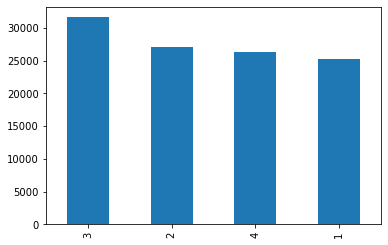

In [14]:
df['app_date'].dt.month.value_counts().plot.bar()

<AxesSubplot:>

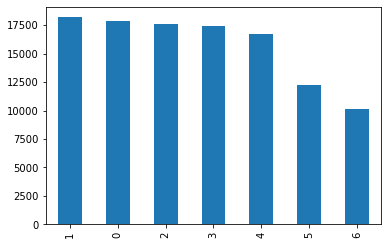

In [15]:
df['app_date'].dt.weekday.value_counts().plot.bar()

Видим, что все анкеты собраны в рамках одного года и примерно равномерно распределены по месяцам - значит, можно добавить такие параметры как номер месяца и день года.
Также попробуем добавить день недели подачи заявки

In [16]:
# формируем новые признаки
df['month'] = df['app_date'].dt.month
df['weekday'] = df['app_date'].dt.weekday
df['day_of_year'] = (df['app_date'] - pd.to_datetime('01/01/2014')).dt.days

In [17]:
df[['app_date','month','weekday','day_of_year']].sample(5)

,app_date,month,weekday,day_of_year
15285,2014-02-21,2,4,51
11776,2014-03-20,3,3,78
58432,2014-02-21,2,4,51
5433,2014-01-22,1,2,21
35461,2014-03-21,3,4,79


<AxesSubplot:>

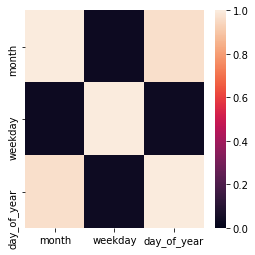

In [18]:
# посмотрим корреляцию добавленных признаков
plt.figure(figsize=(4, 4))
sns.heatmap(df[['month','weekday','day_of_year']].corr().abs(), vmin=0, vmax=1)

Корреляция month и day_of_year высокая, оставим только один. Остальное удалим

In [19]:
df.drop(['app_date', 'month'],  axis = 1, inplace = True)
num_cols.append('day_of_year')
cat_cols.append('weekday')

### 2.2 Категориальные признаки


*********COLUMN: education
Column has 5 unique values
Column has 478 (0.43%%) missing values

Value frequency: 
 SCH    0.528841
GRD    0.317024
UGR    0.134476
PGR    0.017006
ACD    0.002653
Name: education, dtype: float64 



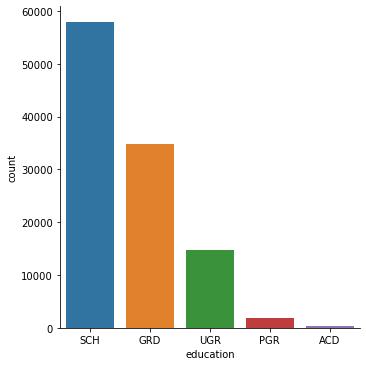


*********COLUMN: region_rating
Column has 7 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 50    0.372054
60    0.217880
40    0.162935
80    0.155881
70    0.084468
Name: region_rating, dtype: float64 



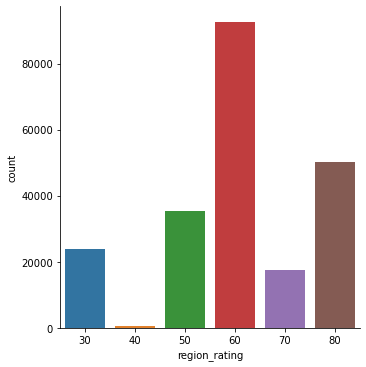


*********COLUMN: home_address
Column has 3 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 2    0.541008
1    0.442023
3    0.016968
Name: home_address, dtype: float64 



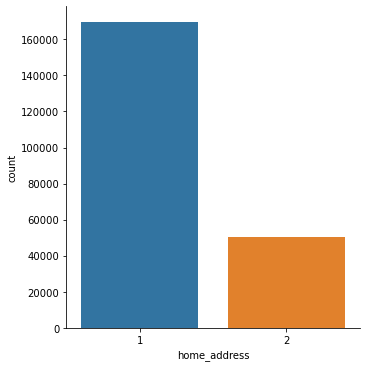


*********COLUMN: work_address
Column has 3 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 3    0.609298
2    0.279270
1    0.111432
Name: work_address, dtype: float64 



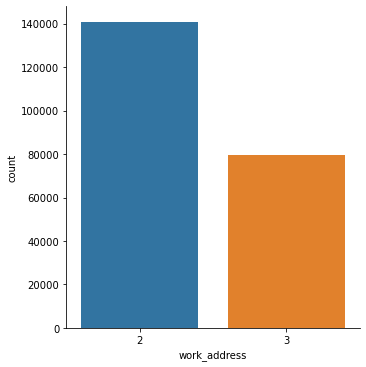


*********COLUMN: sna
Column has 4 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 1    0.641691
4    0.158705
2    0.143734
3    0.055870
Name: sna, dtype: float64 



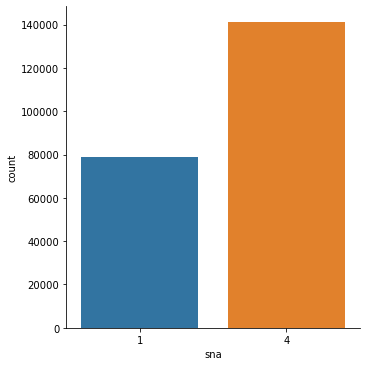


*********COLUMN: first_time
Column has 4 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 3    0.422958
4    0.254358
1    0.166104
2    0.156580
Name: first_time, dtype: float64 



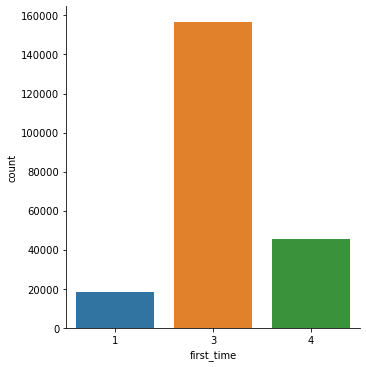


*********COLUMN: weekday
Column has 7 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 1    0.165051
0    0.162127
2    0.159613
3    0.158160
4    0.152059
Name: weekday, dtype: float64 



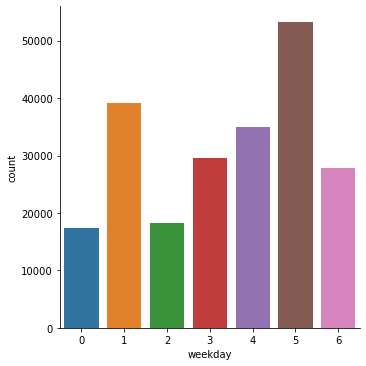

In [20]:
for column in cat_cols:
    describe_categorical_var(df[column])

In [21]:
# заполним пропуски в education модой
df['education'].fillna(df['education'].mode()[0], inplace=True)

In [22]:
# преобразуем education в числовой формат
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df['education'].unique()

array([3, 1, 4, 2, 0])

In [23]:
# преобразуем region_rating в числовой формат
df['region_rating'] = label_encoder.fit_transform(df['region_rating'])
df['region_rating'].unique()

array([3, 6, 4, 2, 5, 0, 1], dtype=int64)

### 2.3 Количественные признаки


*********COLUMN: age


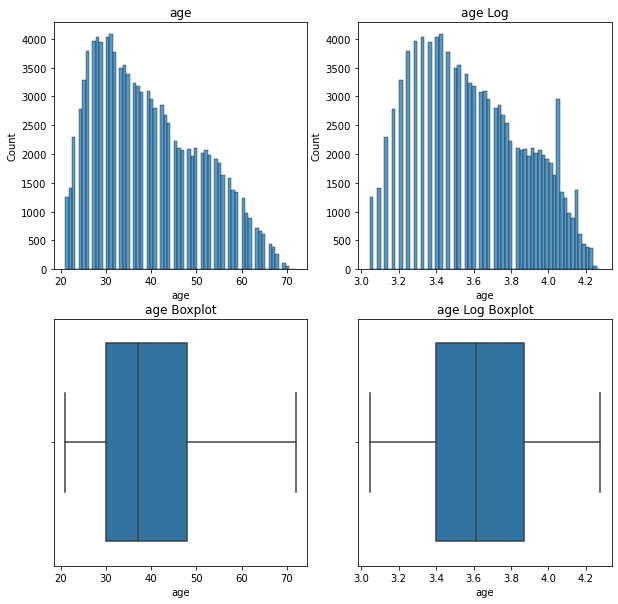

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64 

IQR = 18.0
Outliers: 3.0 and 75.0

Column has 0 (0.0%) missing values


*********COLUMN: decline_app_cnt


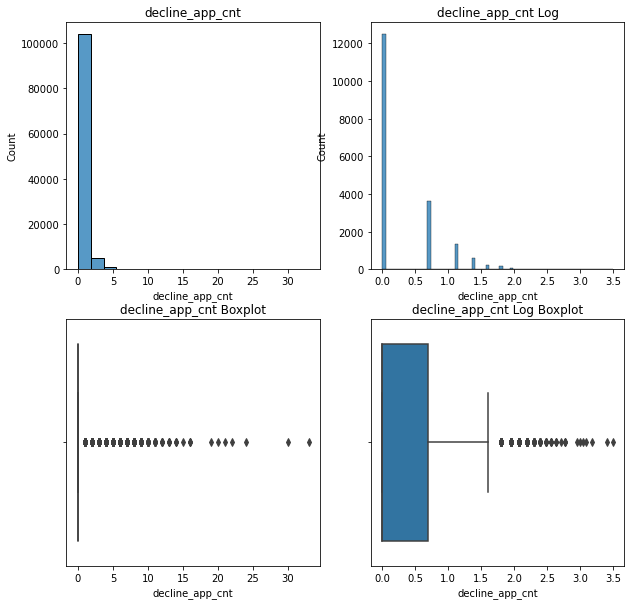

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64 

IQR = 0.0
Outliers: 0.0 and 0.0

Column has 0 (0.0%) missing values


*********COLUMN: score_bki


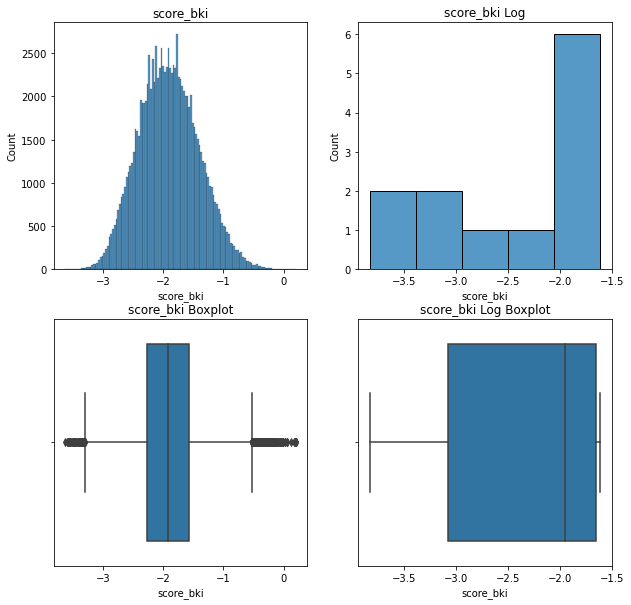

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64 

IQR = 0.6925455175000004
Outliers: -3.299251946250001 and -0.5290698762499992

Column has 0 (0.0%) missing values


*********COLUMN: bki_request_cnt


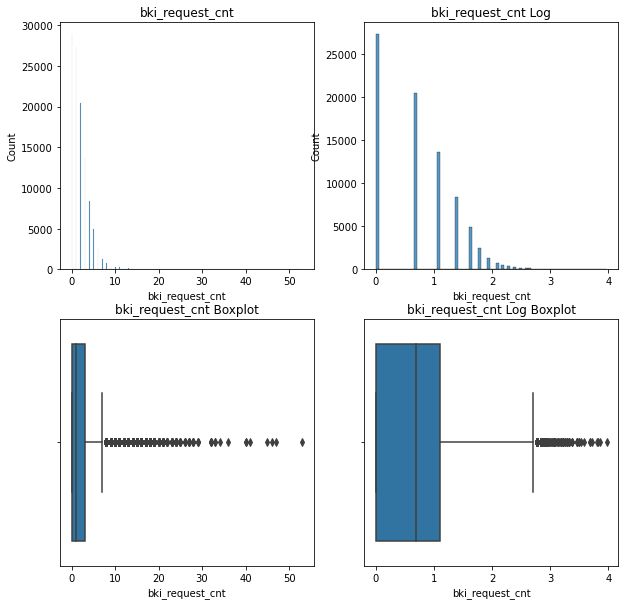

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64 

IQR = 3.0
Outliers: -4.5 and 7.5

Column has 0 (0.0%) missing values


*********COLUMN: income


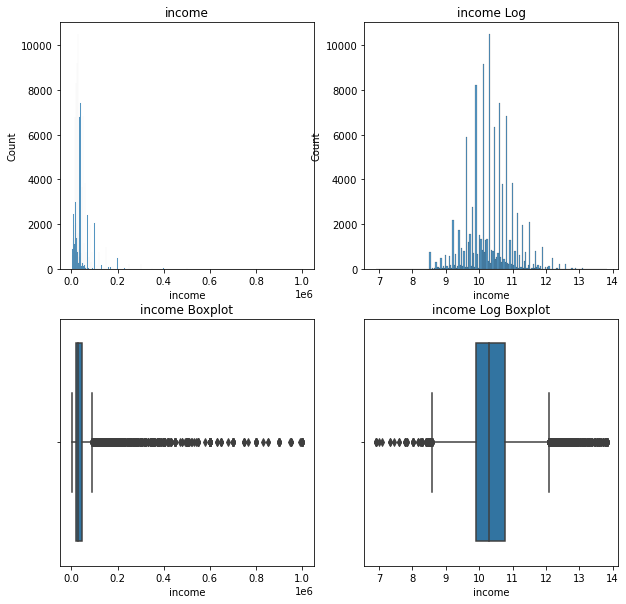

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64 

IQR = 28000.0
Outliers: -22000.0 and 90000.0

Column has 0 (0.0%) missing values


*********COLUMN: day_of_year


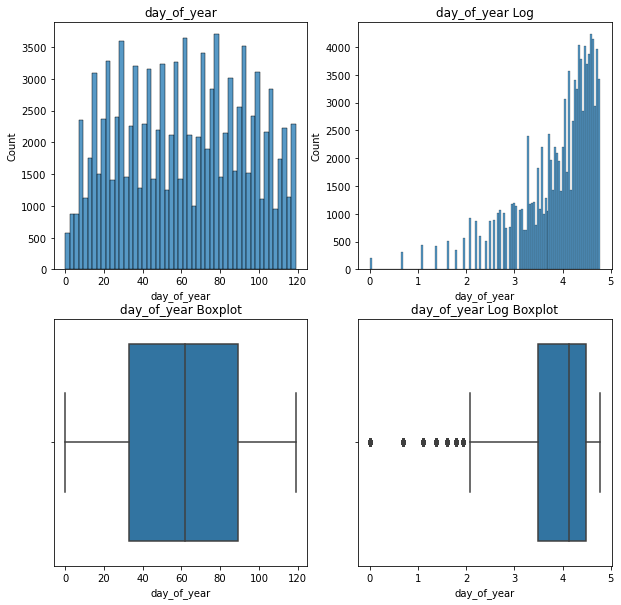

count    110148.000000
mean         60.971466
std          32.076078
min           0.000000
25%          33.000000
50%          62.000000
75%          89.000000
max         119.000000
Name: day_of_year, dtype: float64 

IQR = 56.0
Outliers: -51.0 and 173.0

Column has 0 (0.0%) missing values



In [24]:
for column in num_cols:
    describe_numerical_var(df[column])

Вывод: пропущенных значений нет. Признаки age, decline_app_cnt, bki_request_cnt, income можно логарифмировать, чтобы приблизить их распределение к нормальному. Можно создать новый бинарный признак if_had_decline - если у клиента был отказ

In [25]:
df['if_had_decline'] = df['decline_app_cnt'].apply(lambda x: 0 if x < 1 else 1)
bin_cols.append('if_had_decline')

In [26]:
# прологарифмируем выбранные колонки
for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[col] = np.log(df[col] + 1)

<AxesSubplot:>

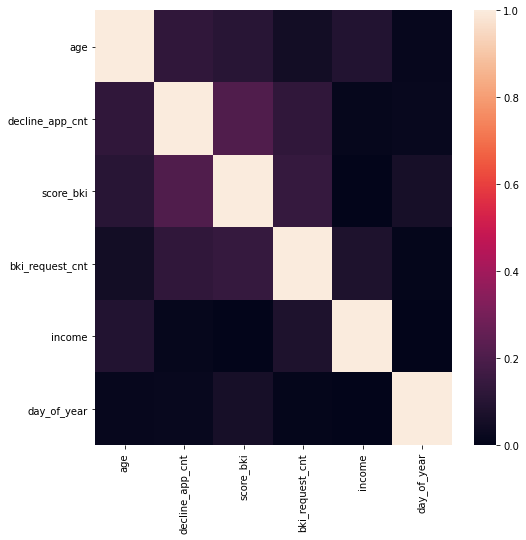

In [27]:
plt.figure(figsize=(8, 8))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Видим, что между количесественными признаками нет высокой корреляции
Посмотрим степень влияния количественных признаков на целевую переменную

<AxesSubplot:>

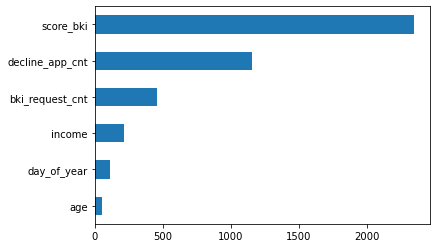

In [28]:
imp_num = pd.Series(f_classif(df[df['if_train']==1][num_cols], df[df['if_train']==1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### 2.4 Бинарные признаки


*********COLUMN: sex
Column has 2 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 F    0.56139
M    0.43861
Name: sex, dtype: float64 



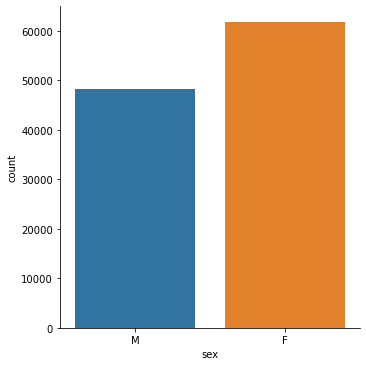


*********COLUMN: car
Column has 2 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 N    0.674456
Y    0.325544
Name: car, dtype: float64 



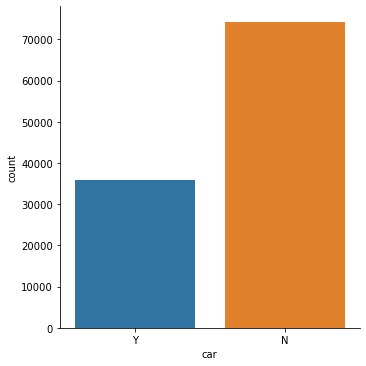


*********COLUMN: car_type
Column has 2 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 N    0.809275
Y    0.190725
Name: car_type, dtype: float64 



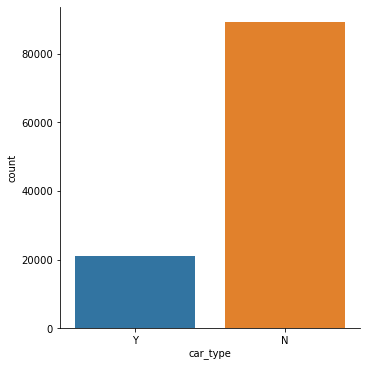


*********COLUMN: good_work
Column has 2 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 0    0.834486
1    0.165514
Name: good_work, dtype: float64 



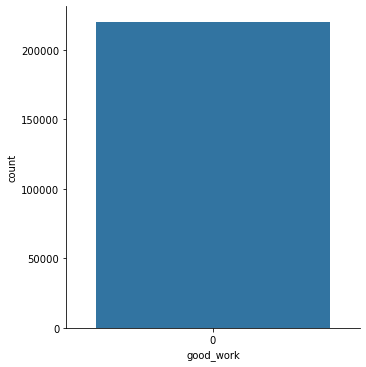


*********COLUMN: foreign_passport
Column has 2 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 N    0.850864
Y    0.149136
Name: foreign_passport, dtype: float64 



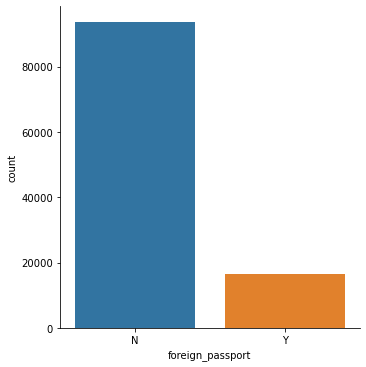


*********COLUMN: if_had_decline
Column has 2 unique values
Column has 0 (0.00%%) missing values

Value frequency: 
 0    0.830437
1    0.169563
Name: if_had_decline, dtype: float64 



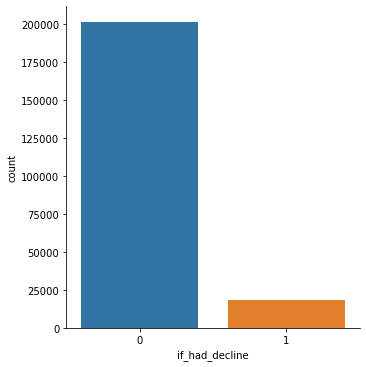

In [29]:
for column in bin_cols:
    describe_categorical_var(df[column])

In [30]:
# закодируем бинарные признаки
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

Посмотрим на значимость категориальных и бинарных признаков

<AxesSubplot:>

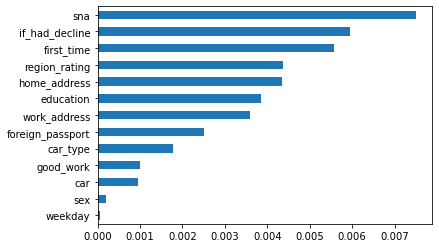

In [31]:
imp_cat = pd.Series(mutual_info_classif(df[df['if_train'] == 1][bin_cols + cat_cols], 
                                        df[df['if_train'] == 1]['default'], 
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

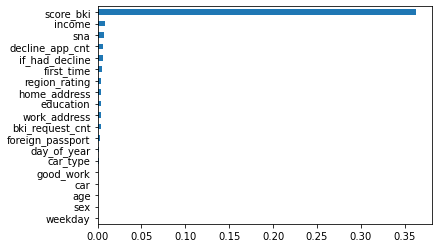

In [32]:
# на все данные в целом
ml_cols = num_cols + bin_cols + cat_cols 
imp_cat = pd.Series(mutual_info_classif(df[ml_cols][df['if_train'] == 1], 
                                        df[df['if_train'] == 1]['default'], 
                                     discrete_features =True), index = ml_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [33]:
# проверим данные
df.sample(5)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,work_address,income,sna,first_time,foreign_passport,default,if_train,weekday,day_of_year,if_had_decline
34645,3,0,3.465736,0,0,0.693147,0,-1.881697,1.609438,2,...,2,10.126671,4,1,0,NaN,0,2,35,1
23054,4,1,3.295837,0,0,0.000000,0,-1.861614,0.000000,3,...,2,10.714440,1,3,0,0.0,1,5,3,0
11257,1,0,4.094345,0,0,0.000000,0,-2.031842,1.098612,3,...,1,10.064798,1,2,0,0.0,1,2,63,0
18149,3,0,3.951244,0,0,0.000000,0,-2.014621,2.564949,3,...,2,10.463132,1,4,0,0.0,1,6,60,0
9398,3,0,3.784190,1,0,0.000000,0,-2.308101,1.609438,2,...,3,9.615872,1,4,0,0.0,1,2,35,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  int32  
 1   sex               110148 non-null  int32  
 2   age               110148 non-null  float64
 3   car               110148 non-null  int32  
 4   car_type          110148 non-null  int32  
 5   decline_app_cnt   110148 non-null  float64
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  float64
 9   region_rating     110148 non-null  int64  
 10  home_address      110148 non-null  int64  
 11  work_address      110148 non-null  int64  
 12  income            110148 non-null  float64
 13  sna               110148 non-null  int64  
 14  first_time        110148 non-null  int64  
 15  foreign_passport  110148 non-null  int32  
 16  default           737

Пропусков нет, все данные закодированы, лишние - убраны

## 3. Препроцессинг

In [35]:
# сбросим индекс - иначе признаки не объединяются в датасет Х
df.reset_index(drop=True, inplace=True)

# создадим dummy переменные
df_dum_cat = pd.get_dummies(df.loc[:, cat_cols], columns = cat_cols)
df_dum_cat.sample(5)

,education_0,education_1,education_2,education_3,education_4,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,...,first_time_2,first_time_3,first_time_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
35475,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
74266,0,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
2409,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
84063,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
18753,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
# стандартизиуем числовые признаки
df_num = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = num_cols)

In [37]:
# сбросим индексы - без этого не работало объединение
#df_num.reset_index(drop=True, inplace=True)
#df_dum_cat.reset_index(drop=True, inplace=True)
#df.reset_index(drop=True, inplace=True)

# объединим все подготовленные признаки в один датасет
X = pd.concat([df_num, df_dum_cat, df[bin_cols], df[['if_train', 'default']]], axis = 1)
#Y = df['default'].values

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 47 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               110148 non-null  float64
 1   decline_app_cnt   110148 non-null  float64
 2   score_bki         110148 non-null  float64
 3   bki_request_cnt   110148 non-null  float64
 4   income            110148 non-null  float64
 5   day_of_year       110148 non-null  float64
 6   education_0       110148 non-null  uint8  
 7   education_1       110148 non-null  uint8  
 8   education_2       110148 non-null  uint8  
 9   education_3       110148 non-null  uint8  
 10  education_4       110148 non-null  uint8  
 11  region_rating_0   110148 non-null  uint8  
 12  region_rating_1   110148 non-null  uint8  
 13  region_rating_2   110148 non-null  uint8  
 14  region_rating_3   110148 non-null  uint8  
 15  region_rating_4   110148 non-null  uint8  
 16  region_rating_5   11

## 4. Строим модель

In [39]:
train_data = X.query('if_train == 1').drop(['if_train'], axis=1)
test_data = X.query('if_train == 0').drop(['if_train'], axis=1)

y = train_data.default.values            
X = train_data.drop(['default'], axis=1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [41]:
print(X.shape, X_train.shape, X_test.shape)

(73799, 45) (59039, 45) (14760, 45)


In [42]:
model = LogisticRegression(max_iter = 2000, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=42)

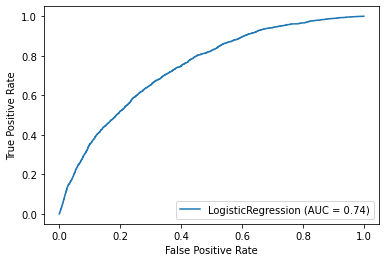

In [43]:
m_1 = ModelData(model, X_test, y_test)
m_1.roc_curve_plot()

Метрика ROC_AUC достаточно велика, то есть даже без подбора параметров мы смогли построить модель, которая работает лучше случайного предстказывания

In [44]:
m_1.get_metrics()

accuracy     0.875068
precision    0.414141
recall       0.022441
F1           0.042575
ROC_AUC      0.744556
dtype: float64

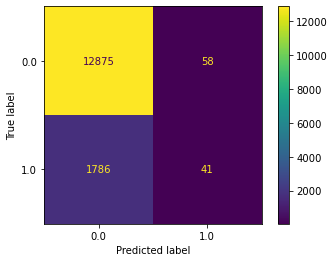

In [45]:
m_1.conf_matrix_plot()

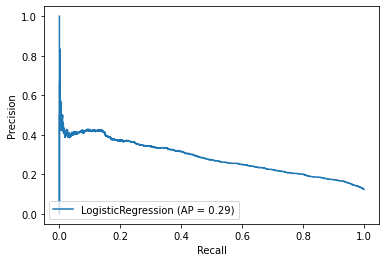

In [46]:
m_1.precision_recall_plot()

Вывод: хотя ROC_AUC и accuracy довольно высокие, f1 и recall - низкие, а FN  высокий - большое количество клиентов, предсказанных как недефолтные, не вернут кредит, банк понесет убытки. Попробуем улучшить модель.

## 6. Улучшаем модель

### 6.1 Сбалансированность данных

<AxesSubplot:xlabel='default', ylabel='count'>

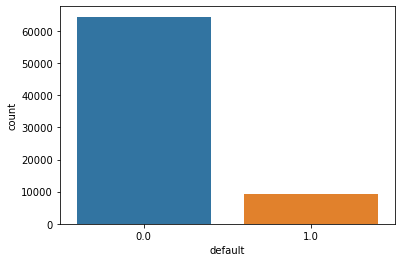

In [47]:
sns.countplot(x='default', data=df)

Видим, что значения не сбалансированы, неплательщиков гораздо меньше. Попробуем сбалансировать

In [48]:
model = LogisticRegression(class_weight='balanced', max_iter = 2000, random_state = RANDOM_SEED)
model.fit(X_train, y_train)
m_2 = ModelData(model, X_test, y_test)

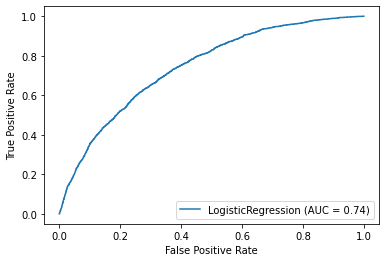

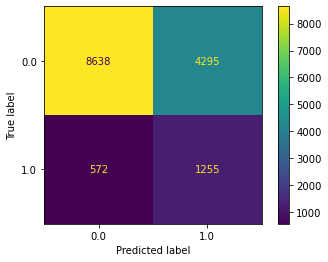

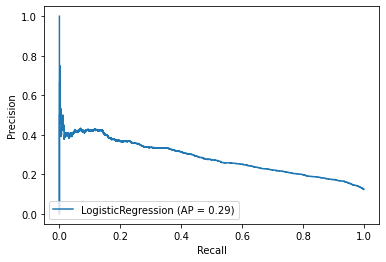

accuracy     0.670257
precision    0.226126
recall       0.686918
F1           0.340247
ROC_AUC      0.744231
dtype: float64

In [49]:
m_2.roc_curve_plot()
m_2.conf_matrix_plot()
m_2.precision_recall_plot()
m_2.get_metrics()

Вывод: видим, что при бидинсировке у нас значительно выросли f1 и recall, FN стал ниже - модель реже ошибается. При этом резко выросли FP - модель сильно перестраховывается и хороших клиентов записывает в возможные "неплательщики" 

### 6.2 Подбор параметров модели

In [50]:
C = np.logspace(-1, 3, 10)
iter_ = 1000
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [51]:
model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)

In [52]:
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# результат
best_param_dict = model_best_params.get_params()
print('Лучшие значения параметров:') 
for param in best_param_dict.keys():
        print('{} = {},'.format(param, best_param_dict[param]))

Лучшие значения параметров:
C = 0.774263682681127,
class_weight = balanced,
dual = False,
fit_intercept = True,
intercept_scaling = 1,
l1_ratio = None,
max_iter = 1000,
multi_class = auto,
n_jobs = None,
penalty = l1,
random_state = 42,
solver = saga,
tol = 0.001,
verbose = 0,
warm_start = False,


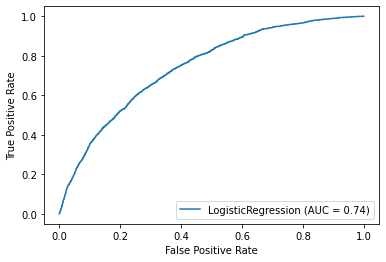

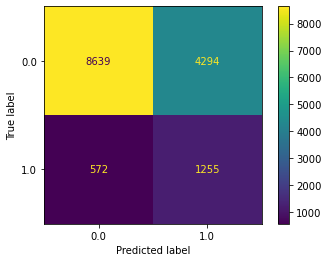

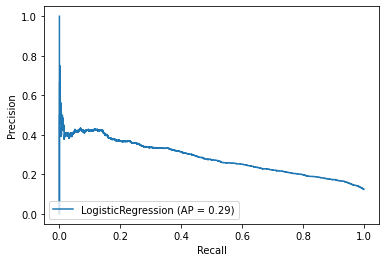

accuracy     0.670325
precision    0.226167
recall       0.686918
F1           0.340293
ROC_AUC      0.744264
dtype: float64

In [53]:
m_3 = ModelData(model_best_params, X_test, y_test)
m_3.roc_curve_plot()
m_3.conf_matrix_plot()
m_3.precision_recall_plot()
m_3.get_metrics()

Видно, что как-то значительно улучшить показатели модели при подборе параметров не удалось. К сожалению, время заканчивается и дальнейшие эксперименты продолжу после публикации этого ответа

## 7. Submission

In [54]:
X_test = test_data.drop(['default'], axis=1)

y_pred_prob = model_best_params.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test['client_id'])
submit['default']=y_pred_prob

submit.to_csv('submission_3.csv', index=False)

## 8. Выводы
1. Благодаря балансировке целевой переменной удалось значительно улучшить значение f1 и уменьшить количество false negative клиентов - мы стали лучше выявлять рискованных клиентов. Возможно, стоит попробовать с under sampling 
2. При этом выросло количество false positive клиентов, что означает, что банк недополучит прибыль
3. Подбор параметров модели не дал значительного улучшения - возможно, с этим надо будет поэкспериментировать еще